In [1]:
from TM1py.Services import TM1Service
from TM1py.Utils import Utils
import pandas as pd
from sklearn.linear_model import LinearRegression
import time
import matplotlib.pyplot as plt
import re
from typing import List

In [12]:
zl_stg=pd.read_csv(r'C:\TM1py\ZL_Amazon_Payments_Data_STG.csv',iterator=True,chunksize=10000,low_memory=False,
                   dtype={'SA Year':'str','Order Year':'str','COA Company':'str','Platform':'str'})

In [3]:
zl_fcst=pd.read_csv(r'C:/DBs_EDU/\ZL_FCST.csv',iterator=True,chunksize=10000,low_memory=False,
                   dtype={'SA Year':'str','Order Year':'str','COA Company':'str','Platform':'str','Value':'float'},thousands=',')

### 实际数部分

In [4]:
import pandas as pd
import asyncio
import nest_asyncio
nest_asyncio.apply()
from concurrent.futures import ThreadPoolExecutor
from typing import List
from TM1py.Services import TM1Service

In [5]:
async def group_async(chunks:'chunks',drop:List,chunk_list:List):
    loop = asyncio.get_event_loop()
    
    with ThreadPoolExecutor(4) as executor:
        #futures = [loop.rudata:'pd.DataFrame',n_in_executor(executor, transfer, tm1_src, tm1_tgr,cube_src, cube_tgr,month_leaf) for month_leaf in leaves]
        futures=[]
        for chunk in chunks:
            
            f=loop.run_in_executor(executor, transfer_c,chunk,drop,chunk_list)
            futures.append(f)
        for future in futures:
            try:
                await future
            except:
                print(future)
                continue




def transfer_c(df:'pd.DataFrame',drop:List,chunk_list:List):

    df.drop(drop,axis=1,inplace=True)
    df_filter=df[(df['Scenario']=='ACT')& (df['Version']=='WIP')&(df['Currency']=='USD')&(df['Country']=='US')&(df['SA Year']=='2018')]
    df_filter_group=df_filter.groupby(['Scenario','SA Year','SA Month','Version','Currency','Country','M ZL Amazon Payments Data STG']).sum()
    df_filter_group.reset_index(inplace=True)
    df_pivot=df_filter_group.pivot(index=['Scenario','SA Year','SA Month','Version','Currency','Country'],columns='M ZL Amazon Payments Data STG'
                      ,values='Value').reset_index().reset_index(drop=True)
    chunk_list.append(df_pivot)
    
def linear_model_ACT(df:'pd.DataFrame'):
    #获取实际数数据df
    
    #日期处理
    df['yearmonth']=df['SA Year']+'-'+df['SA Month'].str.slice(1,3)
    df['yearmonth']=pd.to_datetime(df['yearmonth'])
    df['yearmonth']= df['yearmonth'].apply(lambda x:time.mktime(x.timetuple()))
    #自变量定义
    Z=df[['Fba_fees','Product_sales','Selling_fees','yearmonth']]
    #回归
    lr=LinearRegression()
    lr.fit(Z,df['Quantity'])
    print('intercept:',lr.intercept_)
    print('coef',lr.coef_)
    
    return lr 
    

In [6]:
global chunk_list
chunk_list=[]
asyncio.run(group_async(zl_stg,['Cube','Order Year','Month Day','COA Company','Region State','Region City','Platform','Behavior','Product','Data Source Payments Data STG'],chunk_list))
df_act=pd.concat(chunk_list)
df_act=df_act.groupby(['SA Year','SA Month']).sum().reset_index()

In [430]:
df_act

,SA Year,SA Month,Diff_amount,Fba_fees,Gift_wrap_credits,Gift_wrap_credits_tax,Marketplace_withheld_tax,Other,Other_transaction_fees,Product_sales,Product_sales_tax,Promotional_rebates,Quantity,Selling_fees,Shipping_credits,Shipping_credits_tax
0,2018,M01,9.44,-80794.83,591.49,19.94,-1039.55,-179329.88,-5466.67,278125.55,9309.31,-7238.18,16404.0,-41918.63,8127.11,45.87
1,2018,M02,3.63,-89505.36,921.13,25.85,-1056.99,-181760.24,-8396.76,302684.70,9935.23,-11667.64,16965.0,-44805.96,8893.18,54.88
2,2018,M03,1.62,-87080.99,889.78,28.29,-1099.92,-176654.33,-11220.33,313444.50,10890.58,-8274.96,14460.0,-46967.45,8359.92,53.20
3,2018,M04,0.00,-87063.51,650.40,18.18,-1724.88,-164315.42,-11094.12,312704.52,10543.92,-7334.46,14204.0,-47016.62,8338.84,41.43
4,2018,M05,4.16,-159797.77,2496.24,58.32,-3501.32,-309777.64,-24770.82,587481.84,16359.73,-11667.70,23862.0,-88185.70,13237.44,80.60
5,2018,M06,0.00,-104579.97,660.39,16.94,-2511.55,-243171.29,-15636.31,398570.37,9181.45,-8393.25,16110.0,-60008.45,9414.90,42.11
6,2018,M07,3.32,-117433.94,408.00,13.78,-2579.98,-184745.05,-32685.70,379615.61,10894.31,-17598.02,17894.0,-55904.80,8921.85,35.39
7,2018,M08,4.81,-119972.05,594.56,14.00,-2330.60,-165481.08,-20024.99,367927.91,10719.27,-12770.27,18858.0,-54967.76,10133.96,37.14
8,2018,M09,1.39,-92836.88,582.59,15.75,-1894.38,-212304.67,-7563.00,314518.47,9559.66,-10441.32,13355.0,-46951.22,7392.33,37.98
9,2018,M10,8.32,-88946.45,588.55,16.98,-1779.01,-141250.54,-10172.97,305162.85,9163.30,-24148.90,14981.0,-43624.54,8143.50,29.60


#### 回归结果

In [7]:
lr=linear_model_ACT(df_act)

intercept: 366827.6145985432
coef [-2.35344743e-01  3.75968098e-01  2.59920388e+00 -2.42438904e-04]


### 预测数部分

In [8]:
from TM1py import TM1Service
from TM1py.Utils import Utils
import pandas as pd
import asyncio
import nest_asyncio
nest_asyncio.apply()
from concurrent.futures import ThreadPoolExecutor
from typing import List

In [10]:
async def fcst_async(tm1_tgr:TM1Service,lr:'LinearRegress',chunks:'chunks',cube_tgr:str):
    loop = asyncio.get_event_loop()
    
    with ThreadPoolExecutor(5) as executor:
        #futures = [loop.rudata:'pd.DataFrame',n_in_executor(executor, transfer, tm1_src, tm1_tgr,cube_src, cube_tgr,month_leaf) for month_leaf in leaves]
        futures=[]
        for chunk in chunks:
            
            f=loop.run_in_executor(executor, linear_transfer,tm1_tgr,lr,chunk,cube_tgr)
            futures.append(f)
        for future in futures:
            try:
                await future
            except:
                #print(future)
                continue



def linear_transfer(tm1_tgr:TM1Service,lr:'LinearRegress',df:'pd.DataFrame',cube_tgr:str):
    df_filer=df[df['M ZL Amazon Payments Data STG'].isin(['Fba_fees','Product_sales','Selling_fees'])]
    df_n=transfer_n(df_filer)
    df_tgr=df_n.dropna()
    df=linear_model_FCST(df_tgr,lr)


    #Writing to tgr Cube
    tm1_tgr.cells.write_dataframe(
        cube_name=cube_tgr,
        data=df,
        dimensions=['Scenario','SA Year','SA Month','Version','Order Year','Month Day','COA Company','Currency','Country','Region State'
                   ,'Region City','Platform','Behavior','Product','Data Source Payments Data STG','M ZL Amazon Payments Data STG'],
        increment=False,
        deactivate_transaction_log=True,
        reactivate_transaction_log=True,
        sandbox_name=None,
        use_ti=True,
        skip_non_updateable=True,
        use_changeset=False)
    
def transfer_n(df:'pd.DataFrame'):
      
    df_pivot_n=df.pivot(index=['Scenario','SA Year','SA Month','Version','Order Year','Month Day','COA Company','Currency','Country','Region State'
                              ,'Region City','Platform','Behavior','Product','Data Source Payments Data STG'],columns='M ZL Amazon Payments Data STG'
                      ,values='Value').reset_index().reset_index(drop=True)
        
    return df_pivot_n

def linear_model_FCST(df:'pd.DataFrame',lr:'LinearRegress'):
    #处理目标cube的日期
    df['yearmonth']=df['SA Year']+'-'+df['SA Month'].str.slice(1,3)
    df['yearmonth']=pd.to_datetime(df['yearmonth'])
    df['yearmonth']= df['yearmonth'].apply(lambda x:time.mktime(x.timetuple()))/100000000
    
    #回归预测
    Z_tgr=df[['Fba_fees','Product_sales','Selling_fees','yearmonth']]
    y_predict=lr.predict(Z_tgr)
    df['Quantity']=y_predict
    df.drop(['yearmonth'],axis=1,inplace=True)
    df_ready=df.melt(id_vars=['Scenario','SA Year','SA Month','Version','Order Year','Month Day','COA Company','Currency','Country','Region State'
                        ,'Region City','Platform','Behavior','Product','Data Source Payments Data STG'],var_name=['M ZL Amazon Payments Data STG'],value_name='Values')
    #获取待回写的Dataframe   d
    return df_ready   

#### 回写预测数

In [11]:
tm1_tgr = TM1Service(address="192.168.0.176", port=30015, ssl=False, user="neil", password="123")

asyncio.run(fcst_async(tm1_tgr,lr,zl_fcst,'Bkp_ZL Amazon Payments Data STG'))

C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [382]:
df_ready

,Scenario,SA Year,SA Month,Version,Order Year,Month Day,COA Company,Currency,Country,Region State,Region City,Platform,Behavior,Product,Data Source Payments Data STG,M ZL Amazon Payments Data STG,Values
0,FCST M01 CY2019,2019,M01,WIP,2018,01-02,002,EUR,DE,Baden Württemberg,Bretten,01,商品销售,LSKU1815,Base,Fba_fees,-2.337000
1,FCST M01 CY2019,2019,M01,WIP,2018,01-02,002,EUR,DE,Baden-württemberg,Bad Dürrheim,01,商品销售,LSKU1982,Base,Fba_fees,-5.491000
2,FCST M01 CY2019,2019,M01,WIP,2018,01-02,002,EUR,DE,Baden-württemberg,Buchen (odenwald),01,商品销售,LSKU1982,Base,Fba_fees,-2.337000
3,FCST M01 CY2019,2019,M01,WIP,2018,01-02,002,EUR,DE,Baden-württemberg,Hermaringen,01,商品销售,LSKU1483,Base,Fba_fees,-3.049500
4,FCST M01 CY2019,2019,M01,WIP,2018,01-02,002,EUR,DE,Baden-württemberg,Knittlingen,01,商品销售,LSKU1680,Base,Fba_fees,-2.878500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10043,FCST M01 CY2019,2019,M01,WIP,2018,01-05,002,USD,US,Ny,Saratoga Springs,01,商品销售,LSKU1220,Base,Quantity,-118.793049
10044,FCST M01 CY2019,2019,M01,WIP,2018,01-05,002,USD,US,Ny,Shrub Oak,01,商品销售,LSKU1220,Base,Quantity,-118.793049
10045,FCST M01 CY2019,2019,M01,WIP,2018,01-05,002,USD,US,Ny,West Harrison,01,商品销售,LSKU1262,Base,Quantity,-118.927161
10046,FCST M01 CY2019,2019,M01,WIP,2018,01-05,002,USD,US,Ny,White Plains,01,商品销售,LSKU1615,Base,Quantity,-118.615221


#### Matplotlib

##### 关于预测模型不准确的分析

In [375]:
 #日期处理
 #聚合数据
    df_act['yearmonth']=df_act['SA Year']+'-'+df_act['SA Month'].str.slice(1,3)
    df_act['yearmonth']=pd.to_datetime(df_act['yearmonth'])

In [13]:
#明细数据
n=1
for chunk in zl_stg:
    chunk
    if n==1:
        break
df_act_n=chunk 
chunk_list_plot=[]
df_filter=df_act_n[(df_act_n['Scenario']=='ACT')& (df_act_n['Version']=='WIP')&(df_act_n['Currency']=='USD')&(df_act_n['Country']=='US')&(df_act_n['SA Year']=='2018')]
df_pivot=df_filter.pivot(index=['Scenario','SA Year','SA Month','Version','Currency','Country','Cube','Order Year','Month Day','COA Company','Region State','Region City','Platform','Behavior','Product','Data Source Payments Data STG'],columns='M ZL Amazon Payments Data STG'
                      ,values='Value').reset_index().reset_index(drop=True)
chunk_list_plot.append(df_pivot)
df_act_n_plot=pd.concat(chunk_list_plot)
 #日期处理
df_act_n_plot['yearmonth']=df_act_n_plot['SA Year']+'-'+df_act_n_plot['SA Month'].str.slice(1,3)
df_act_n_plot['yearmonth']=pd.to_datetime(df_act_n_plot['yearmonth'])

C:\Users\User\AppData\Roaming\Python\Python36\site-packages\matplotlib\collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


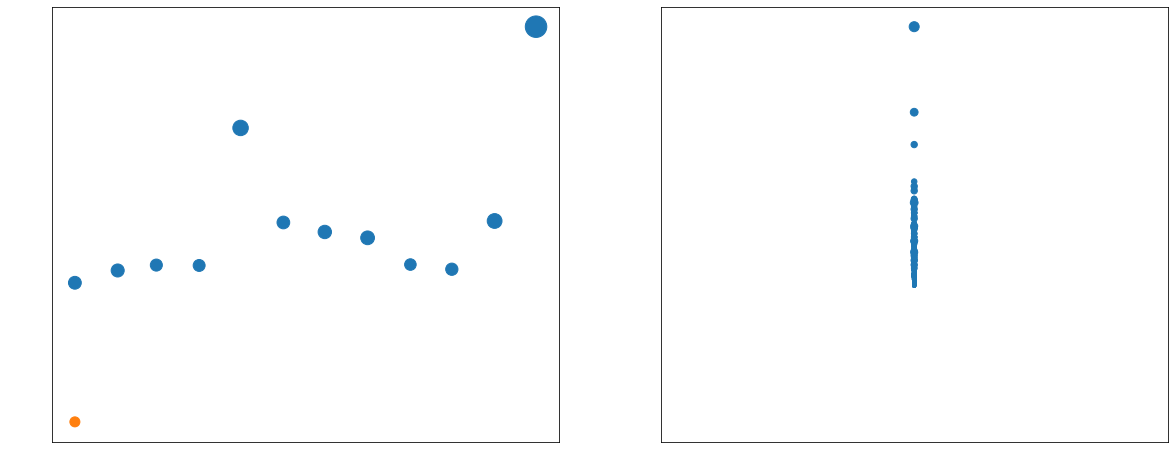

In [425]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
ax = plt.gca()
ax.tick_params(axis='y', colors='#FFFFFF', width=1)
ax.tick_params(axis='x', colors='#FFFFFF', width=1)
plt.scatter(df_act['yearmonth'],df_act['Product_sales'],s=df_act['Quantity']/100)
plt.scatter(df_act_n_plot['yearmonth'],df_act_n_plot['Product_sales'],s=df_act_n_plot['Quantity']*10)
plt.subplot(1,2,2)
ax = plt.gca()
ax.tick_params(axis='y', colors='#FFFFFF', width=1)
ax.tick_params(axis='x', colors='#FFFFFF', width=1)
plt.scatter(df_act_n_plot['yearmonth'],df_act_n_plot['Product_sales'],s=df_act_n_plot['Quantity']*10)
plt.show()

In [15]:
df_act_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Cube                           10000 non-null  object 
 1   Scenario                       10000 non-null  object 
 2   SA Year                        10000 non-null  object 
 3   SA Month                       10000 non-null  object 
 4   Version                        10000 non-null  object 
 5   Order Year                     10000 non-null  object 
 6   Month Day                      10000 non-null  object 
 7   COA Company                    10000 non-null  object 
 8   Currency                       10000 non-null  object 
 9   Country                        10000 non-null  object 
 10  Region State                   10000 non-null  object 
 11  Region City                    10000 non-null  object 
 12  Platform                       10000 non-null  